<a href="https://colab.research.google.com/github/Gurukannan/Billing-Application/blob/master/USE_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
%tensorflow_version 1.x

import tensorflow
print(tensorflow.__version__)

!pip install tensorflow==1.15.3

TensorFlow is already loaded. Please restart the runtime to change versions.
2.4.1


In [25]:
import pandas as pd
movie_lines_features = ["LineID", "Character", "Movie", "Name", "Line"]
movie_lines = pd.read_csv("movie_lines.txt", sep = "\+\+\+\$\+\+\+", engine = "python", index_col = False, names = movie_lines_features)

# Using only the required columns, namely, "LineID" and "Line"
movie_lines = movie_lines[["LineID", "Line"]]

# Strip the space from "LineID" for further usage and change the datatype of "Line"
movie_lines["LineID"] = movie_lines["LineID"].apply(str.strip)

KeyError: ignored

In [13]:
movie_lines.dropna(inplace=True)
movie_lines.head()


,LineID,Line
0,L1045,They do not!
1,L1044,They do to!
2,L985,I hope so.
3,L984,She okay?
4,L925,Let's go.


In [14]:
movie_lines.shape

(304446, 2)

In [52]:
df=pd.read_excel('sentences2.xlsx',header=None)
df.dropna(inplace=True)
df[0].astype(str)
texts=df[0].to_list()
texts = texts[:10000]
texts[:10]

['Shpere says Plano, what is that',
 'How can i try on these frames to see what they look like on me?',
 'how can i activate the camera?',
 'I need the highest anti glare. My last pair I bought still has halos with traffic lights etc at night. Which one should o pick?',
 'can i customize a base curve for glasses?',
 'I just got a new prescription with prism 1 adjustments for both eyes. The value is 0.50 out one each lens. Can I do that with Zenni glasses? And how?',
 'hi, did you guys remove the option for tints? I used to be able to chose between grey tinti 50% and grey tinti 80%',
 'Has o3437822197 arrived in Southern California?',
 'How do I remove the military, first responder, student, teacher, medical, & nurse 10% from my account?',
 'My 20% off was not applied.']

In [53]:
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

#tf.logging.set_verbosity(tf.logging.ERROR)
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2")


def embed_texts(texts):

    # Reduce logging output.
    #tf.math.logging.set_verbosity(tf.math.logging.ERROR)

    with tf.Session() as session:
        session.run([tf.global_variables_initializer(), tf.tables_initializer()])
        embeddings = session.run(embed(texts))

    return np.array(embeddings).tolist()

embeddings = embed_texts(texts)

In [54]:
from sklearn.manifold import TSNE

mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


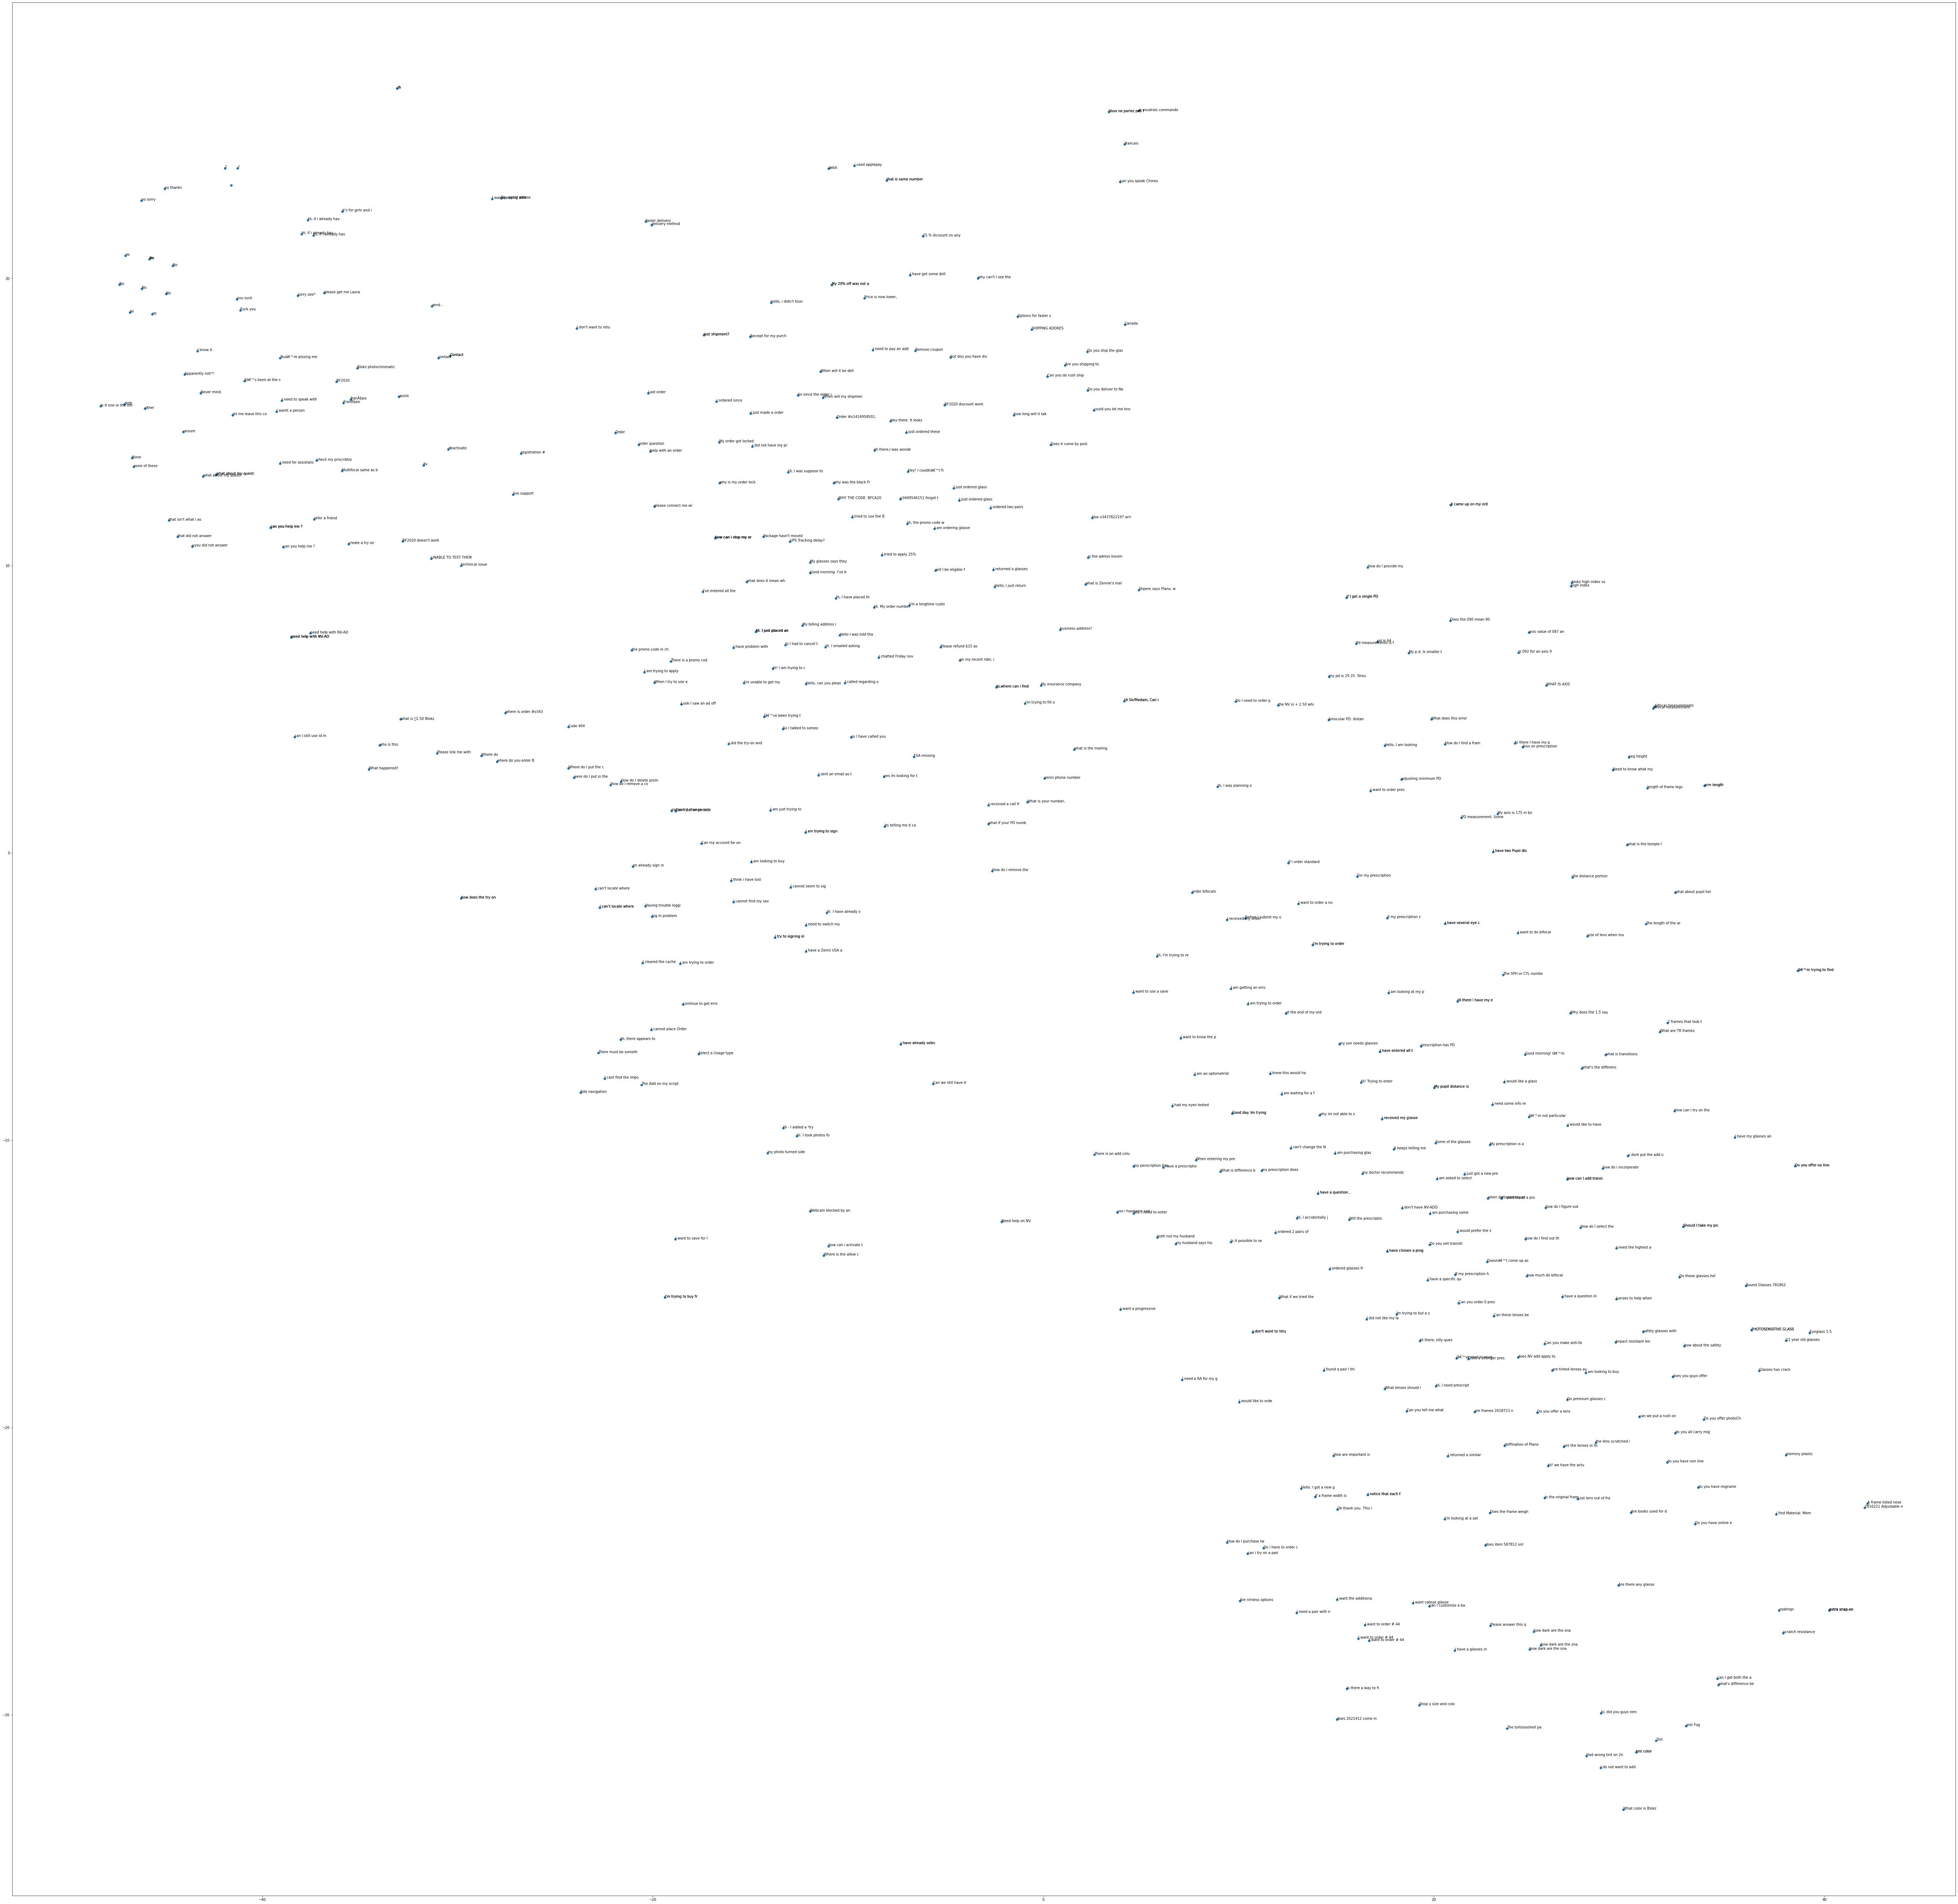

In [55]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(100,100))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
plt.scatter(x, y)

for i, txt in enumerate(texts):
    plt.annotate(txt[:20], (x[i], y[i]))

In [56]:

import re

embedding_file = "sentence_embeddings.kv"
with open(embedding_file, "w") as o:
    o.write(f'{len(embeddings)} {len(embeddings[0])}\n')
    for text, embedding in zip(texts[:len(embeddings)], embeddings):
        text = re.sub("\s+", "_", text)
        string_embedding = " ".join([str(v) for v in embedding])
        o.write(f'{text} {string_embedding}\n')

In [57]:
from gensim.models import KeyedVectors
sentence_vectors = KeyedVectors.load_word2vec_format('sentence_embeddings.kv', binary=False)

In [58]:
from sklearn.cluster import AgglomerativeClustering

clusterer = AgglomerativeClustering(n_clusters=4, affinity="euclidean", linkage="ward")
clusters = clusterer.fit_predict(embeddings)

In [59]:
import pandas as pd

df = pd.DataFrame({"text": texts, "cluster": clusters})

for cl in [2]: 
    print(df.loc[df['cluster'] == cl])

                                                  text  cluster
15                                    I wantt a person        2
24                               check my priscribtion        2
55                             Youâ€™re pissing me off        2
65                                                None        2
69                                                   .        2
..                                                 ...      ...
442                                               both        2
454  I don't want to return. Otherwise, they are pe...        2
470       i need for assistance than you are providing        2
489                                           you suck        2
490       Itâ€™s been at the same status for too long.        2

[74 rows x 2 columns]


In [60]:
df

,text,cluster
0,"Shpere says Plano, what is that",0
1,How can i try on these frames to see what they...,1
2,how can i activate the camera?,0
3,I need the highest anti glare. My last pair I ...,1
4,can i customize a base curve for glasses?,1
...,...,...
494,I have my glasses and l have bifocal but you d...,1
495,Can you do rush shipping on orders,0
496,Options for faster shipping???,0
497,when do I send my prescription? When do I see ...,1


In [61]:
df.to_excel('clustered.xlsx')